This jupyter notebook is prepared in Kaggle. Please make sure to set the accelerator to be `GPU` before running the notebook.

I have uploaded the `mil_ird_challenge.zip` by "+ Add data" button, with the dataset name to be `IRD Challenge`. Once uploaded, the zip file will be automatically extracted and the data inside the zip file can be found in the path `/kaggle/input/ird-challenge/mil_ird_challenge`. 

**PLEASE CHANGE THE `data_root_dir` IF THE PATH IS NOT SET IN ABOVE STEPS.**

For the trained model will be saved in `model_save_path`, please feel free to update the path according to your running environment.

In [3]:
data_root_dir = '/kaggle/input/ird-challenge/mil_ird_challenge/' 
model_save_path = '/kaggle/working/predictor.ag'

# Installing and Importing Required Packages

In [ ]:
%%capture
!pip install autogluon
!pip install "mxnet-cu110"

In [2]:
import os
import logging 
import autogluon.core as ag
from autogluon.vision import ImagePredictor, ImageDataset
import numpy as np 
import pandas as pd 

logging.basicConfig(level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler())

/opt/conda/lib/python3.7/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.8.0` and `torch==1.10.1+cu102` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


# Load Dataset and Train a Model with AutoGluon

In [4]:
# load training and validation dataest
train_dataset = ImageDataset.from_folder(os.path.join(data_root_dir, 'train/'))
valid_dataset = ImageDataset.from_folder(os.path.join(data_root_dir, 'test/'))
train_dataset.info(), valid_dataset.info()

<class 'gluoncv.auto.data.dataset.ImageClassificationDataset'>
RangeIndex: 13953 entries, 0 to 13952
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   13953 non-null  object
 1   label   13953 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 218.1+ KB
<class 'gluoncv.auto.data.dataset.ImageClassificationDataset'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   3000 non-null   object
 1   label   3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


(None, None)

Since the challenge cares about the prediction accuracy much, I decided to use the pre-set config `best_quality` to performance the model and hyperparameter search.

The `best_quality` config mainly employs the transformer-based vision model in published in 2021.
- Swim Transformer from [Swin Transformer: Hierarchical Vision Transformer using Shifted Windows](https://openaccess.thecvf.com/content/ICCV2021/papers/Liu_Swin_Transformer_Hierarchical_Vision_Transformer_Using_Shifted_Windows_ICCV_2021_paper.pdf)
- Twins-PCPVT from [Twins: Revisiting the Design of Spatial Attention in Vision Transformers](https://arxiv.org/pdf/2104.13840.pdf)
- CoaT from [Co-Scale Conv-Attentional Image Transformers](https://arxiv.org/pdf/2104.06399.pdf)

ImagePredictor sets accuracy as default eval_metric for classification problems.
Presets specified: ['best_quality']
Reset labels to [0, 1, 2, 3, 4, 5]
Reset labels to [0, 1, 2, 3, 4, 5]
The number of requested GPUs is greater than the number of available GPUs.Reduce the number to 1
Starting HPO experiments
modified configs(<old> != <new>): {
root.misc.seed       42 != 200
root.misc.num_workers 4 != 2
root.img_cls.model   resnet101 != swin_base_patch4_window7_224
root.train.early_stop_baseline 0.0 != -inf
root.train.lr        0.01 != 0.0003162278
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.batch_size 32 != 8
}
Saved config to /kaggle/working/2352e51f/.trial_0/config.yaml
Model swin_base_patch4_window7_224 created, param count:                                         86749374
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 34.045697 samples/sec	acc

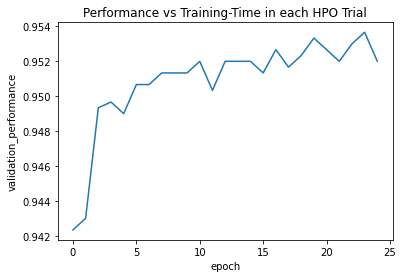

Finished, total runtime is 10953.55 s
{ 'best_config': { 'augmentation': { 'auto_augment': None,
                                     'color_jitter': 0.4,
                                     'cutmix': 0.0,
                                     'cutmix_minmax': None,
                                     'drop': 0.0,
                                     'drop_block': None,
                                     'drop_path': None,
                                     'hflip': 0.5,
                                     'mixup': 0.0,
                                     'mixup_mode': 'batch',
                                     'mixup_off_epoch': 0,
                                     'mixup_prob': 1.0,
                                     'mixup_switch_prob': 0.5,
                                     'no_aug': False,
                                     'ratio': (0.75, 1.3333333333333333),
                                     'scale': (0.08, 1.0),
                                     'smoot

In [6]:
# I limit the model search to use only `swin_base_patch4_window7_224`, and time for running to be 3 hrs.
# `swin_base_patch4_window7_224` gives the best result in dry run for the first few epoches.
# More information about the `swin_base_patch_window7_224` can be found in
# https://github.com/microsoft/Swin-Transformer/blob/main/configs/swin_base_patch4_window7_224.yaml

predictor = ImagePredictor()
predictor.fit(
    train_data=train_dataset,
    tuning_data=valid_dataset,
    presets='best_quality',
    time_limit=3*60*60,
    hyperparameters={
        'model': 'swin_base_patch4_window7_224',
        'early_stop_patience': 10
    }
)

# save the model
predictor.save(model_save_path)

In [7]:
predictor.fit_summary()

{'train_acc': 0.9257075471698113,
 'valid_acc': 0.9536666666666667,
 'total_time': 10953.225689411163,
 'best_config': {'img_cls': {'model': 'swin_base_patch4_window7_224',
   'pretrained': True,
   'global_pool_type': None},
  'data': {'img_size': None,
   'input_size': None,
   'crop_pct': 0.99,
   'mean': None,
   'std': None,
   'interpolation': '',
   'validation_batch_size_multiplier': 1},
  'optimizer': {'opt': 'sgd',
   'opt_eps': None,
   'opt_betas': None,
   'momentum': 0.9,
   'weight_decay': 0.0001,
   'clip_grad': None,
   'clip_mode': 'norm'},
  'train': {'batch_size': 8,
   'sched': 'step',
   'lr': 0.0003162278,
   'lr_noise': None,
   'lr_noise_pct': 0.67,
   'lr_noise_std': 1.0,
   'lr_cycle_mul': 1.0,
   'lr_cycle_limit': 1,
   'transfer_lr_mult': 0.01,
   'output_lr_mult': 0.1,
   'warmup_lr': 0.0001,
   'min_lr': 1e-05,
   'epochs': 200,
   'start_epoch': 0,
   'decay_epochs': 30,
   'warmup_epochs': 3,
   'cooldown_epochs': 10,
   'patience_epochs': 10,
   'decay

# Make Prediction on the `submission.csv`
The files in the `submission.csv` is not only coming from `pred`, so a dictionary `file_to_paths` is built to map the filename in `submission.csv` to the absolute path of the file from `train`, `test` and `pred`.

In [14]:
from copy import copy

In [15]:
# load the trained predictor
load_predictor_from_file = False

if load_predictor_from_file:
    if os.path.isfile(model_save_path):
        predictor2 = ImagePredictor()
        predictor2.load(model_save_path)
    else:
        print(f"model is not found in `{model_save_path}`")
else:
    predictor2 = copy(predictor)
    print("using the existing model.")
print(predictor2.fit_summary())

using the existing model.
{'train_acc': 0.9257075471698113, 'valid_acc': 0.9536666666666667, 'total_time': 10953.225689411163, 'best_config': {'img_cls': {'model': 'swin_base_patch4_window7_224', 'pretrained': True, 'global_pool_type': None}, 'data': {'img_size': None, 'input_size': None, 'crop_pct': 0.99, 'mean': None, 'std': None, 'interpolation': '', 'validation_batch_size_multiplier': 1}, 'optimizer': {'opt': 'sgd', 'opt_eps': None, 'opt_betas': None, 'momentum': 0.9, 'weight_decay': 0.0001, 'clip_grad': None, 'clip_mode': 'norm'}, 'train': {'batch_size': 8, 'sched': 'step', 'lr': 0.0003162278, 'lr_noise': None, 'lr_noise_pct': 0.67, 'lr_noise_std': 1.0, 'lr_cycle_mul': 1.0, 'lr_cycle_limit': 1, 'transfer_lr_mult': 0.01, 'output_lr_mult': 0.1, 'warmup_lr': 0.0001, 'min_lr': 1e-05, 'epochs': 200, 'start_epoch': 0, 'decay_epochs': 30, 'warmup_epochs': 3, 'cooldown_epochs': 10, 'patience_epochs': 10, 'decay_rate': 0.1, 'bn_momentum': None, 'bn_eps': None, 'sync_bn': False, 'early_stop

In [16]:
file_to_paths = dict()
for dirname, _, filenames in os.walk(data_root_dir):
    for filename in filenames:
        file_to_paths[filename] = os.path.join(dirname, filename)

In [17]:
pred = pd.read_csv(os.path.join(data_root_dir, 'submission.csv'))
pred['image'] = pred['File'].apply(lambda x: file_to_paths[x])
pred.head()

,File,Prediction,image
0,17410.jpg,NaN,/kaggle/input/ird-challenge/mil_ird_challenge/...
1,1760.jpg,NaN,/kaggle/input/ird-challenge/mil_ird_challenge/...
2,17625.jpg,NaN,/kaggle/input/ird-challenge/mil_ird_challenge/...
3,17567.jpg,NaN,/kaggle/input/ird-challenge/mil_ird_challenge/...
4,17509.jpg,NaN,/kaggle/input/ird-challenge/mil_ird_challenge/...


In [19]:
# make prediction
pred_label = predictor2.predict(pred['image'].to_frame())

# save prediction with image id
pred['Prediction'] = pred_label
pred

,File,Prediction,image
0,17410.jpg,4,/kaggle/input/ird-challenge/mil_ird_challenge/...
1,1760.jpg,0,/kaggle/input/ird-challenge/mil_ird_challenge/...
2,17625.jpg,1,/kaggle/input/ird-challenge/mil_ird_challenge/...
3,17567.jpg,1,/kaggle/input/ird-challenge/mil_ird_challenge/...
4,17509.jpg,4,/kaggle/input/ird-challenge/mil_ird_challenge/...
...,...,...,...
95,17402.jpg,4,/kaggle/input/ird-challenge/mil_ird_challenge/...
96,17381.jpg,5,/kaggle/input/ird-challenge/mil_ird_challenge/...
97,17411.jpg,4,/kaggle/input/ird-challenge/mil_ird_challenge/...
98,17593.jpg,2,/kaggle/input/ird-challenge/mil_ird_challenge/...


In [20]:
# print the prediction result in 100 chars string.
''.join([str(x) for x in list(pred_label)])

'4011424513045102255244014554113403020043055341144333400253032105135035521225052254551332323522145425'